In [1]:
!date

Wed Sep 20 14:02:02 EDT 2023


In [3]:
%%time
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m
from datetime import datetime
now = datetime.now
T0 = now()

from IPython import display
import sys
import seaborn as sns
from IPython import display


CPU times: user 1.24 s, sys: 237 ms, total: 1.48 s
Wall time: 2.81 s


In [4]:
%%time
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 9.78 µs


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [8]:
dataset_path_bg = './Data/pytorch-data/xl_121_15_action_data_bg'
dataset_path_seg = './Data/pytorch-data/xl_121_15_action_data_seg'

cats = os.listdir(os.path.join(dataset_path_bg,'train'))
cats.sort()
cats = np.array(cats)

n_cats = len(cats)

train_images = []
train_cats = []
train_cats_idx = []
for idx,cat in enumerate(cats):
    temp = [f for f in os.listdir(os.path.join(dataset_path_bg,'train',cat)) if f.endswith('.jpg')]
    temp.sort()
    train_images.append(temp)
    train_cats.append( list(np.repeat(cat,len(temp))) )
    train_cats_idx.append( list(np.repeat(idx,len(temp))) )

val_images = []
val_cats = []
val_cats_idx = []
for idx,cat in enumerate(cats):
    temp = [f for f in os.listdir(os.path.join(dataset_path_bg,'val',cat)) if f.endswith('.jpg')]
    temp.sort()
    val_images.append(temp)
    val_cats.append( list(np.repeat(cat,len(temp))) )
    val_cats_idx.append( list(np.repeat(idx,len(temp))) )

#val_images_n = np.array([len(val) for val in train_images])
val_images_n = np.array([len(val) for val in val_images])

In [9]:
test_images = []
test_cats = []
test_cats_idx = []
for idx,cat in enumerate(cats):
    temp = [f for f in os.listdir(os.path.join(dataset_path_bg,'test',cat)) if f.endswith('.jpg')]
    temp.sort()
    test_images.append(temp)
    test_cats.append( list(np.repeat(cat,len(temp))) )
    test_cats_idx.append( list(np.repeat(idx,len(temp))) )

#val_images_n = np.array([len(val) for val in train_images])
test_images_n = np.array([len(val) for val in test_images])

In [10]:
# CHECK that train images have BG and SEG versions
train_vec_im = np.hstack(train_images)
train_vec_cat = np.hstack(train_cats)
train_vec_n = len(train_vec_im)
train_vec_cat_idx = np.hstack(train_cats_idx)

In [11]:
# CHECK that val images have BG and SEG versions
val_vec_im = np.hstack(val_images)
val_vec_cat = np.hstack(val_cats)
val_vec_n = len(val_vec_im)
val_vec_cat_idx = np.hstack(val_cats_idx)

In [12]:
assert train_vec_n==95056, 'check failed'

In [14]:
training_data_bg = np.load('./Data/pytorch-data/DomainNet-frames-bgg-95056.npy')

In [15]:
%%time
training_data_seg = np.load('./Data/pytorch-data/DomainNet-frames-seg-95056.npy')

CPU times: user 75 µs, sys: 8.55 s, total: 8.55 s
Wall time: 18.6 s


In [16]:
val_data_bg = np.load('./Data/pytorch-data/DomainNet-frames-bg-6936-val.npy')
val_data_seg = np.load('./Data/pytorch-data/DomainNet-frames-seg-6936-val.npy')

In [17]:
def divide_chunks(l, n):
    # Yield successive n-sized
    # chunks from l.
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

val_chunks = list(divide_chunks(np.random.permutation(np.arange(val_vec_n)), 32))

In [20]:
batch_size=32

def get_batch_from_loaded(batch_size):
    cat_idx = np.random.randint(low=0,high=n_cats,size=batch_size) # Select random categories (idx)
    im_idx = np.array([np.random.choice(np.nonzero(train_vec_cat_idx==c)[0]) for c in cat_idx]) # Select random images
    batch_bg = training_data_bg[im_idx,:,:,:] # slice BG data
    batch_seg = training_data_seg[im_idx,:,:,:] # slice SEG data
    return cat_idx,batch_bg,batch_seg

In [21]:
def dashboard():

    #plt.close()
    
    nrows=4
    ncols=3
    c = 0
    plt.figure(figsize=(15,10))

    display.clear_output(wait=True);
    display.display(plt.gcf());
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(loss_train_bg)
    plt.title('Train loss BG')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(loss_train_seg)
    plt.title('Train loss SEG')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(loss_train_comb)
    plt.title('Train loss COMB')
    plt.legend(['BG','SEG'])
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(acc_train_bg)
    plt.title('Train ACC BG')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(acc_train_seg)
    plt.title('Train ACC SEG')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(acc_train_comb)
    plt.title('Train ACC COMB')
    
    ## Validation
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(loss_val_bg)
    plt.title('VAL loss BG')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(loss_val_seg)
    plt.title('VAL loss SEG')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(loss_val_comb)
    plt.title('VAL loss COMB')
    plt.legend(['BG','SEG'])
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(acc_val_bg)
    plt.title('val ACC BG')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(acc_val_seg)
    plt.title('val ACC SEG')
    
    c+=1;plt.subplot(nrows,ncols,c)
    plt.plot(acc_val_comb)
    plt.title('val ACC COMB')    
    
    t = str(now()-t00).split('.')[0]
    plt.suptitle(f'Epoch {epoch} elapsed T: {t}')
    
    plt.tight_layout()
    sys.stdout.flush()

In [23]:
batch_lbls,batch_bg,batch_seg = get_batch_from_loaded(batch_size=32)

Text(0.5, 0.96, 'SEG')

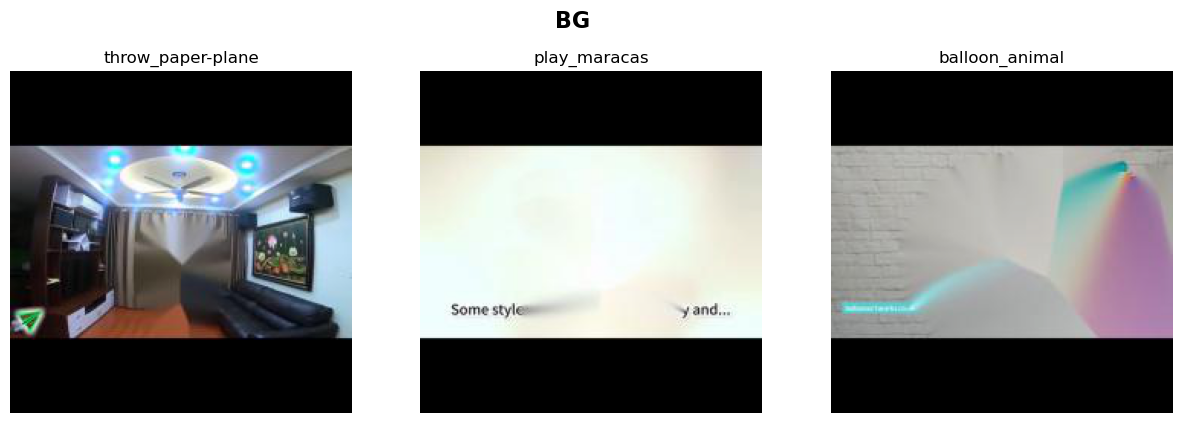

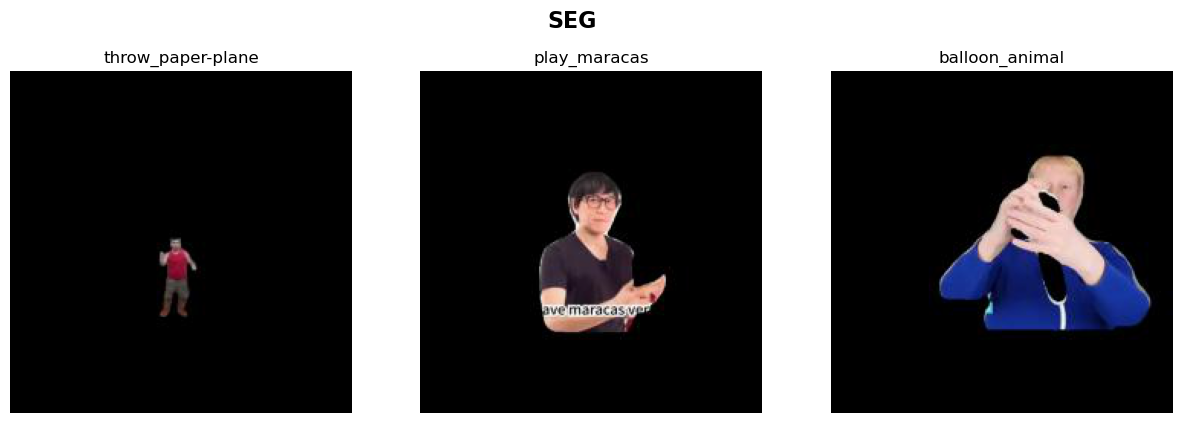

In [24]:
############ BG 
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(batch_bg[0,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[0]])
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(batch_bg[1,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[1]])
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(batch_bg[2,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[2]])
plt.axis('off')
plt.suptitle('BG',fontsize=16,fontweight='bold',y=.96)

############ SEG
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(batch_seg[0,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[0]])
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(batch_seg[1,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[1]])
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(batch_seg[2,:,:].swapaxes(0,1).swapaxes(2,1).astype(float) )
plt.title(cats[batch_lbls[2]])
plt.axis('off')
plt.suptitle('SEG',fontsize=16,fontweight='bold',y=.96)

In [25]:
## BG NET
bg_net = resnet50()
bg_net.fc = nn.Linear(bg_net.fc.in_features,n_cats)

bg_net.half();
bg_net = bg_net.to(device)

In [26]:
## SEG NET
seg_net = resnet50()
seg_net.fc = nn.Linear(seg_net.fc.in_features,n_cats)

seg_net.half();
seg_net = seg_net.to(device)

In [27]:
class CombinedNet(nn.Module):

    def __init__(self,bg_net,seg_net):
        super(CombinedNet, self).__init__()
        self.bg_net = bg_net 
        self.seg_net = seg_net 

    def forward(self,batch_bg,batch_seg):
        out_bg = self.bg_net(batch_bg)
        out_seg = self.seg_net(batch_seg)
        out_combined = out_bg+out_seg
        
        return out_bg,out_seg,out_combined

In [28]:
## COMBnet
combinedNet = CombinedNet(bg_net,seg_net)

combinedNet.half()
combinedNet.to(device)

criterion = nn.CrossEntropyLoss()                                 # specify the loss function
optimizer = optim.SGD(combinedNet.parameters(), lr=0.001, momentum=0.9)     # specify the optimizer

In [31]:
save_dir = './Data/pytorch-data/weights/domain_net_working-1'
safe_mkdir(save_dir)

In [32]:
loss_train_bg = []
loss_train_seg = []
loss_train_comb = []
acc_train_bg = []
acc_train_seg = []
acc_train_comb = []

loss_val_bg = []
loss_val_seg = []
loss_val_comb = []
acc_val_bg = []
acc_val_seg = []
acc_val_comb = []

In [33]:
do_train = False

In [34]:
if do_train==True:
    t00 = now()
    for epoch in tqdm( range(100) ):
        
        temp_bg_loss = 0
        temp_seg_loss = 0
        temp_comb_loss = 0
        
        combinedNet.train()
        for b in range(500):
        
            optimizer.zero_grad();
    
            batch_lbls,batch_bg,batch_seg = get_batch_from_loaded(batch_size=32) # NEW FASTER WAY! 0.o
            
            batch_lbls = torch.from_numpy(batch_lbls).long()
            batch_bg = torch.from_numpy(batch_bg).half()
            batch_seg = torch.from_numpy(batch_seg).half()
            
            batch_lbls = batch_lbls.cuda()
            batch_bg = batch_bg.cuda()
            batch_seg = batch_seg.cuda()
    
            bg_outputs,seg_outputs,comb_outputs = combinedNet(batch_bg,batch_seg)
    
            
            bg_loss = criterion(bg_outputs, batch_lbls)
            temp_bg_loss+=bg_loss.data.item() # Collect BATCH loss BG
            
            
            seg_loss = criterion(seg_outputs, batch_lbls)
            temp_seg_loss+=seg_loss.data.item() # Collect BATCH loss BG
    
            comb_loss = criterion(comb_outputs, batch_lbls)
            temp_comb_loss+=seg_loss.data.item() # Collect BATCH loss BG
    
            total_loss = bg_loss+seg_loss+comb_loss
            total_loss.backward()
            optimizer.step()
    
        # Collect data end of each epoch
        loss_train_bg.append( temp_bg_loss/b )
        loss_train_seg.append( temp_seg_loss/b )
        loss_train_comb.append( temp_comb_loss/b )
    
        acc_train_bg.append( (bg_outputs.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        acc_train_seg.append( (seg_outputs.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        acc_train_comb.append( (comb_outputs.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean() )
        
        ### VALIDATION DATA
        combinedNet.eval()
    
        temp_acc_val_bg = 0
        temp_acc_val_seg = 0
        temp_acc_val_comb = 0
        for v,val_chunk in enumerate(val_chunks):
    
            # load as numpy
            batch_lbls = val_vec_cat_idx[val_chunk]
            batch_bg = val_data_bg[val_chunk,:,:,:]
            batch_seg = val_data_seg[val_chunk,:,:,:]
    
            # convert to torch
            batch_lbls = torch.from_numpy(batch_lbls).long()
            batch_bg = torch.from_numpy(batch_bg).half()
            batch_seg = torch.from_numpy(batch_seg).half()
    
            # pass to cuda
            batch_lbls = batch_lbls.cuda()
            batch_bg = batch_bg.cuda()
            batch_seg = batch_seg.cuda()
    
            # pass to network
            bg_outputs,seg_outputs,comb_outputs = combinedNet(batch_bg,batch_seg)
            
            bg_loss = criterion(bg_outputs, batch_lbls)
            temp_bg_loss+=bg_loss.data.item() # Collect BATCH loss BG
            
            seg_loss = criterion(seg_outputs, batch_lbls)
            temp_seg_loss+=seg_loss.data.item() # Collect BATCH loss BG
    
            comb_loss = criterion(comb_outputs, batch_lbls)
            temp_comb_loss+=comb_loss.data.item() # Collect BATCH loss BG
    
            temp_acc_val_bg+=(bg_outputs.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean()
            temp_acc_val_seg+=(seg_outputs.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean()
            temp_acc_val_comb+=(comb_outputs.detach().cpu().numpy().argmax(axis=1)==batch_lbls.detach().cpu().numpy()).mean()
        
        
        loss_val_bg.append( temp_bg_loss/v )
        loss_val_seg.append( temp_seg_loss/v )
        loss_val_comb.append( temp_comb_loss/v )
        acc_val_bg.append( temp_acc_val_bg/v )
        acc_val_seg.append( temp_acc_val_seg/v )
        acc_val_comb.append( temp_acc_val_comb/v )
    
        dashboard()

In [35]:
if do_train == True:

    torch.save(combinedNet.state_dict(), os.path.join(save_dir,'weights'))
    np.save(os.path.join(save_dir,'loss_val_bg.npy'),loss_val_bg) 
    np.save(os.path.join(save_dir,'loss_val_seg.npy'),loss_val_seg) 
    np.save(os.path.join(save_dir,'loss_val_comb.npy'),loss_val_comb) 
    np.save(os.path.join(save_dir,'acc_val_bg.npy'),acc_val_bg) 
    np.save(os.path.join(save_dir,'acc_val_seg.npy'),acc_val_seg) 
    np.save(os.path.join(save_dir,'acc_val_comb.npy'),acc_val_comb) 
    
    
    np.save(os.path.join(save_dir,'loss_train_bg.npy'),loss_train_bg) 
    np.save(os.path.join(save_dir,'loss_train_seg.npy'),loss_train_seg) 
    np.save(os.path.join(save_dir,'loss_train_comb.npy'),loss_train_comb) 
    np.save(os.path.join(save_dir,'acc_train_bg.npy'),acc_train_bg) 
    np.save(os.path.join(save_dir,'acc_train_seg.npy'),acc_train_seg) 
    np.save(os.path.join(save_dir,'acc_train_comb.npy'),acc_train_comb) 


In [36]:
#dashboard()

## LOAD TRAINED

In [37]:
del training_data_bg
del training_data_seg
del val_data_bg
del val_data_seg

In [38]:
combinedNet.load_state_dict(torch.load(os.path.join(save_dir,'weights')));
combinedNet.eval()

loss_val_bg = np.load(os.path.join(save_dir,'loss_val_bg.npy'))
loss_val_seg = np.load(os.path.join(save_dir,'loss_val_seg.npy'))
loss_val_comb = np.load(os.path.join(save_dir,'loss_val_comb.npy'))
acc_val_bg = np.load(os.path.join(save_dir,'acc_val_bg.npy'))
acc_val_seg = np.load(os.path.join(save_dir,'acc_val_seg.npy'))
acc_val_comb = np.load(os.path.join(save_dir,'acc_val_comb.npy'))

In [ ]:
t00 = now()
epoch = 100
dashboard()

In [40]:
test_images = []
test_cats = []
test_cats_idx = []
for idx,cat in enumerate(cats):
    temp = [f for f in os.listdir(os.path.join(dataset_path_bg,'test',cat)) if f.endswith('.jpg')]
    temp.sort()
    test_images.append(temp)
    test_cats.append( list(np.repeat(cat,len(temp))) )
    test_cats_idx.append( list(np.repeat(idx,len(temp))) )

#val_images_n = np.array([len(val) for val in train_images])
test_images_n = np.array([len(val) for val in test_images])
test_lbls = np.hstack(test_cats_idx)

In [41]:
test_data_orig = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-orig.npy')
test_data_bg = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-bg.npy')
test_data_seg = np.load('./Data/pytorch-data/DomainNet-frames-test-7697-seg.npy')
print(test_data_orig.shape)

(7697, 3, 224, 224)


In [42]:
test_data_n = test_data_orig.shape[0]

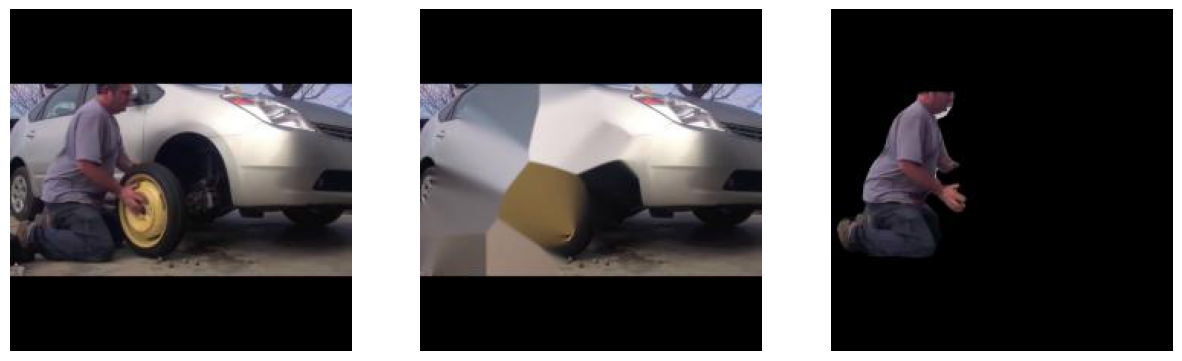

In [43]:
i = 1
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);
plt.imshow(test_data_orig[i,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));
plt.axis('off');

plt.subplot(1,3,2);
plt.imshow(test_data_bg[i,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));
plt.axis('off');

plt.subplot(1,3,3);
plt.imshow(test_data_seg[i,:,:].swapaxes(0,1).swapaxes(2,1).astype(float));
plt.axis('off');

In [44]:
def test_trained_combinedNet(data_bg,data_seg,lbls):
    
    combinedNet.eval()
    n = data_bg.shape[0]
    chunks = list(divide_chunks(np.arange(n), 32))
    chunk = chunks[0]
    
    batch_lbls = lbls[chunk]
    batch_bg = data_bg[chunk,:,:,:]
    batch_seg = data_seg[chunk,:,:,:]
    
    # convert to torch
    batch_lbls = torch.from_numpy(batch_lbls).long()
    batch_bg = torch.from_numpy(batch_bg).half()
    batch_seg = torch.from_numpy(batch_seg).half()
    
    # pass to cuda
    batch_lbls = batch_lbls.cuda()
    batch_bg = batch_bg.cuda()
    batch_seg = batch_seg.cuda()
    
    # pass to network
    bg_outputs,seg_outputs,comb_outputs = combinedNet(batch_bg,batch_seg)
    
    bg_outputs = bg_outputs.detach().cpu().numpy()
    seg_outputs = seg_outputs.detach().cpu().numpy()
    comb_outputs = comb_outputs.detach().cpu().numpy()
    
    for i in tqdm( range(1,len(chunks)) ):
        chunk = chunks[i]
        
        batch_lbls = lbls[chunk]
        batch_bg = data_bg[chunk,:,:,:]
        batch_seg = data_seg[chunk,:,:,:]
        
        # convert to torch
        batch_lbls = torch.from_numpy(batch_lbls).long()
        batch_bg = torch.from_numpy(batch_bg).half()
        batch_seg = torch.from_numpy(batch_seg).half()
        
        # pass to cuda
        batch_lbls = batch_lbls.cuda()
        batch_bg = batch_bg.cuda()
        batch_seg = batch_seg.cuda()
        
        # pass to network
        chunk_bg_outputs,chunk_seg_outputs,chunk_comb_outputs = combinedNet(batch_bg,batch_seg)
    
        bg_outputs = np.vstack((bg_outputs,chunk_bg_outputs.detach().cpu().numpy()))
        seg_outputs = np.vstack((seg_outputs,chunk_seg_outputs.detach().cpu().numpy()))
        comb_outputs = np.vstack((comb_outputs,chunk_comb_outputs.detach().cpu().numpy()))


    return bg_outputs,seg_outputs,comb_outputs

In [55]:
bg_outputs,seg_outputs,comb_outputs = test_trained_combinedNet(test_data_bg,test_data_seg,test_lbls)

100%|█████████████████████████████████████████| 240/240 [00:08<00:00, 28.98it/s]


In [56]:
bg_acc = (bg_outputs.argmax(axis=1)==test_lbls).mean()
seg_acc = (seg_outputs.argmax(axis=1)==test_lbls).mean()
comb_acc = (comb_outputs.argmax(axis=1)==test_lbls).mean()

In [57]:
bg_acc_top5 = np.array([test_lbls[i] in list(np.argsort(bg_outputs[i,:])[-5::]) for i in range(len(test_lbls))]).mean()
seg_acc_top5 = np.array([test_lbls[i] in list(np.argsort(seg_outputs[i,:])[-5::]) for i in range(len(test_lbls))]).mean()
comb_acc_top5 = np.array([test_lbls[i] in list(np.argsort(comb_outputs[i,:])[-5::]) for i in range(len(test_lbls))]).mean()

Text(0.5, 1.0, 'DomainNet: Top5 acc')

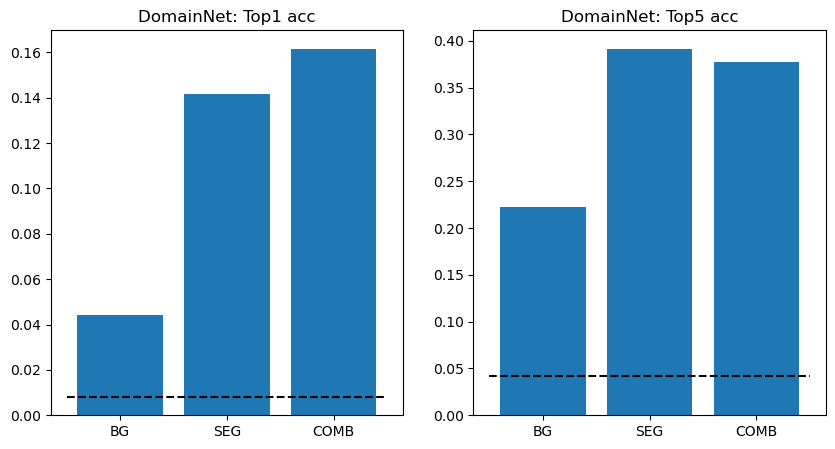

In [58]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

xs = [0,1,2]
ys = [bg_acc,seg_acc,comb_acc];
plt.bar(xs,ys);
plt.xticks(xs,labels=['BG','SEG','COMB']);
plt.plot([-.5,2.5],[1/121,1/121],'k--')
plt.title('DomainNet: Top1 acc')

plt.subplot(1,2,2)

xs = [0,1,2]
ys = [bg_acc_top5,seg_acc_top5,comb_acc_top5]
plt.bar(xs,ys);
plt.xticks(xs,labels=['BG','SEG','COMB']);
plt.plot([-.5,2.5],[.042,.042],'k--')
plt.title('DomainNet: Top5 acc')

In [81]:
np.savez_compressed('./ICLR24/Data_DomainNet.npz',
                    test_lbls = test_lbls,
                    bg_outputs = bg_outputs,
                    seg_outputs = seg_outputs,
                    comb_outputs = comb_outputs,
                    bg_acc = bg_acc,
                    seg_acc = seg_acc,
                    comb_acc = comb_acc,
                    bg_acc_top5 = bg_acc_top5,
                    seg_acc_top5 = seg_acc_top5,
                    comb_acc_top5 = comb_acc_top5,
                    )